# QRT ENS Data Challenge 2023
## Data Specs (Copied from Official)
- `X_train` and `X_test` both have $35$ columns that represent the same explanatory variables but over different time periods. 

- `X_train` and `Y_train` share the same column `ID` - each row corresponds to a unique ID associated wwith a day and a country. 

- The target of this challenge `TARGET` in `Y_train` corresponds to the price change for daily futures contracts of 24H electricity baseload. 

- **You will notice some columns have missing values**.

Input data sets comprise 35 columns:

ID: Unique row identifier, associated with a day (DAY_ID) and a country (COUNTRY),

DAY_ID: Day identifier - dates have been anonymized, but all data corresponding to a specific day is consistent,

COUNTRY: Country identifier - DE = Germany, FR = France,
and then contains daily commodity price variations,

GAS_RET: European gas,

COAL_RET: European coal,

CARBON_RET: Carbon emissions futures,

#### Weather measures (daily, in the country x)

x_TEMP: Temperature,

x_RAIN: Rainfall,

x_WIND: Wind,


#### Energy production measures (daily, in the country x)

x_GAS: Natural gas,

x_COAL: Hard coal,

x_HYDRO: Hydro reservoir,

x_NUCLEAR: Daily nuclear production,

x_SOLAR: Photovoltaic,

x_WINDPOW: Wind power,

x_LIGNITE: Lignite,

#### Electricity use metrics (daily, in the country x)

x_CONSUMPTON: Total electricity consumption,

x_RESIDUAL_LOAD: Electricity consumption after using all renewable energies,

x_NET_IMPORT: Imported electricity from Europe,

x_NET_EXPORT: Exported electricity to Europe,

DE_FR_EXCHANGE: Total daily electricity exchange between Germany and France,

FR_DE_EXCHANGE: Total daily electricity exchange between France and Germany.

Output data sets are composed of two columns:

ID: Unique row identifier - corresponding to the input identifiers,

TARGET: Daily price variation for futures of 24H electricity baseload.

In [67]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import itertools as it
from scipy.stats import spearmanr
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression as mir
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn import linear_model
from sklearn.cluster import KMeans
import xgboost as xgb

In [229]:
df = pd.read_csv('x_train.csv')
y = pd.read_csv('y_train.csv')
true_test = pd.read_csv('x_test.csv')
pd.set_option('display.max_columns', None)

bx_train, bx_test, by_train, by_test = train_test_split(df, y, test_size=0.33, random_state=88)

### Benchmarking
Running linear regression on the same train test split for a basic performance benchmark. For now we just replace NaN values with 0.

In [94]:
br_lr = LinearRegression()

br_x_train_clean, br_x_test_clean = bx_train.fillna(0).drop(['ID', 'DAY_ID', 'COUNTRY'], axis=1), bx_test.fillna(0).drop(['ID', 'DAY_ID', 'COUNTRY'], axis=1)
y_train_clean, y_test_clean = by_train['TARGET'], by_test['TARGET']

br_lr.fit(br_x_train_clean, y_train_clean)

br_test_output = br_lr.predict(br_x_test_clean)

def metric_train(output, test):
    return  spearmanr(output, test).correlation

print('Spearman correlation for the benchmark: {:.1f}%'.format(100 * metric_train(br_test_output, y_test_clean)))
lr_test_output = br_lr.predict(br_x_train_clean)
print(spearmanr(lr_test_output, y_train_clean).correlation)

Spearman correlation for the benchmark: 21.4%
0.26312112997079024


### Exploratory Data Analysis

In [70]:
df_numeric = df.drop(['ID', 'DAY_ID', 'COUNTRY', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1)
df_numeric = df_numeric.fillna(df_numeric.median(numeric_only=True))

In [71]:
df.isna().sum()

ID                    0
DAY_ID                0
COUNTRY               0
DE_CONSUMPTION        0
FR_CONSUMPTION        0
DE_FR_EXCHANGE       25
FR_DE_EXCHANGE       25
DE_NET_EXPORT       124
FR_NET_EXPORT        70
DE_NET_IMPORT       124
FR_NET_IMPORT        70
DE_GAS                0
FR_GAS                0
DE_COAL               0
FR_COAL               0
DE_HYDRO              0
FR_HYDRO              0
DE_NUCLEAR            0
FR_NUCLEAR            0
DE_SOLAR              0
FR_SOLAR              0
DE_WINDPOW            0
FR_WINDPOW            0
DE_LIGNITE            0
DE_RESIDUAL_LOAD      0
FR_RESIDUAL_LOAD      0
DE_RAIN              94
FR_RAIN              94
DE_WIND              94
FR_WIND              94
DE_TEMP              94
FR_TEMP              94
GAS_RET               0
COAL_RET              0
CARBON_RET            0
dtype: int64

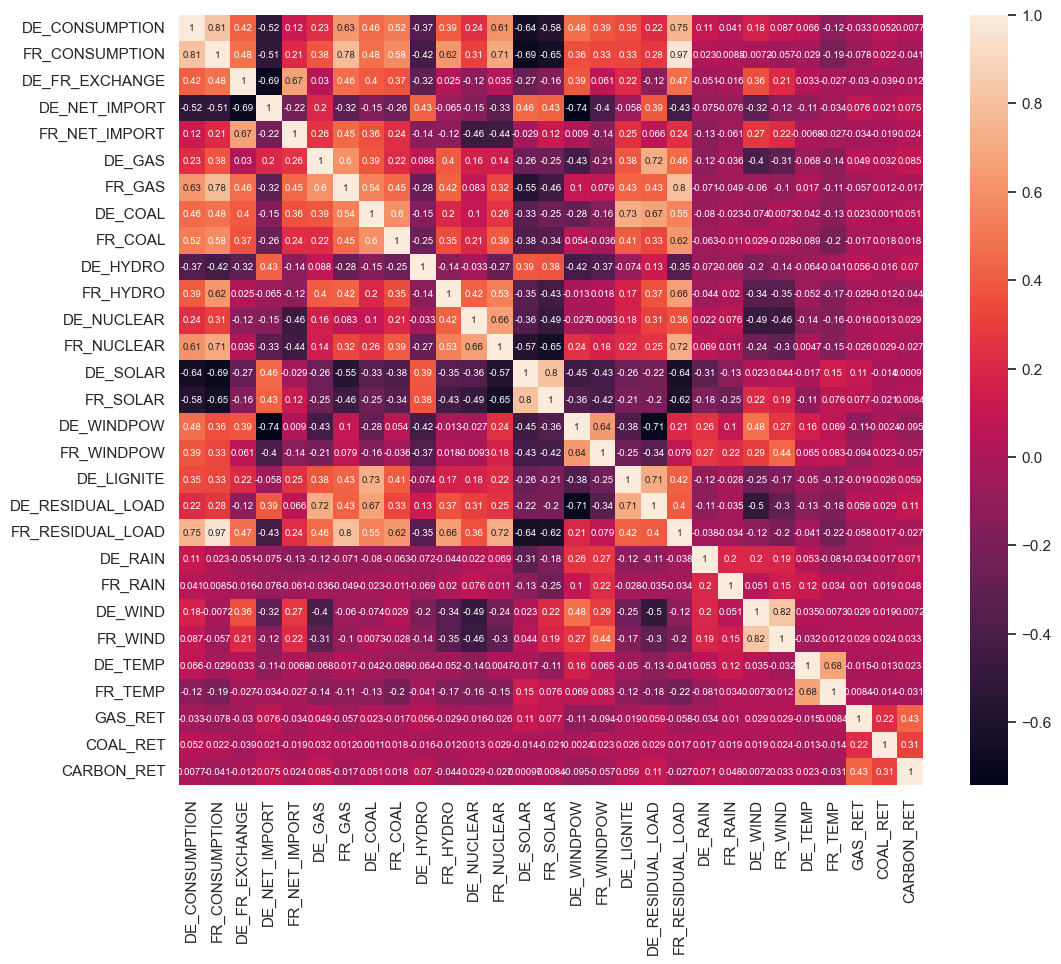

In [72]:
plt.clf()
sns.set(rc={'figure.figsize':(12,10)})
sns.heatmap(df_numeric[df_numeric.columns].corr(), annot=True, annot_kws={"fontsize":7})
plt.show()

<Figure size 1200x1000 with 0 Axes>

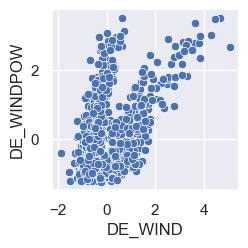

In [73]:
plt.clf()
sns.pairplot(data=df, x_vars='DE_WIND', y_vars='DE_WINDPOW')
plt.show()

<Figure size 1200x1000 with 0 Axes>

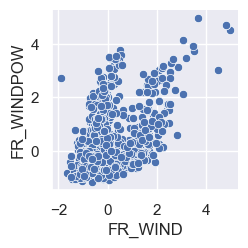

In [74]:
plt.clf()
sns.pairplot(data=df, x_vars='FR_WIND', y_vars='FR_WINDPOW')
plt.show()

<Figure size 1200x1000 with 0 Axes>

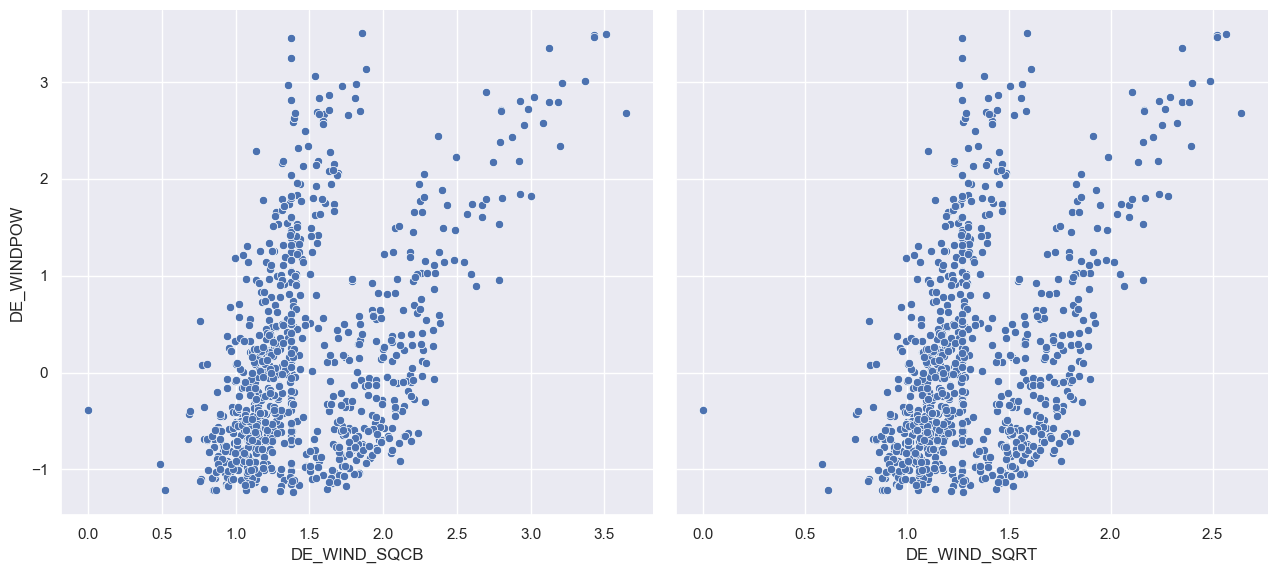

In [75]:
plt.clf()
df_numeric['DE_WIND_OTHER_POW'] = (df_numeric['DE_WIND'] - df_numeric['DE_WIND'].min()).pow(0.75)
df_numeric['DE_WIND_SQCB'] = (df_numeric['DE_WIND'] - df_numeric['DE_WIND'].min()).pow(2.0/3.0)
df_numeric['DE_WIND_SQRT'] = (df_numeric['DE_WIND'] - df_numeric['DE_WIND'].min()).pow(0.5)
diag = sns.pairplot(data=df_numeric, x_vars=['DE_WIND_SQCB', 'DE_WIND_SQRT'], y_vars='DE_WINDPOW')
diag.fig.set_size_inches(14, 7)
diag.set(xlim=(None, None))
plt.show()

0.8463291113363425
0.847451208947195
0.8474240140657444
0.8467743688812757


<Figure size 1200x1000 with 0 Axes>

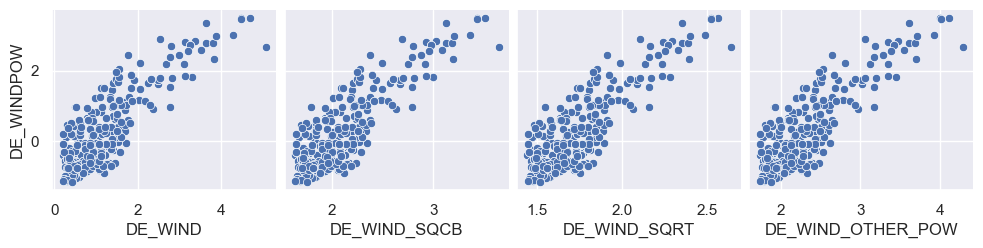

In [76]:
winds = df_numeric[['DE_WIND', 'DE_WIND_SQCB', 'DE_WIND_SQRT', 'DE_WIND_OTHER_POW', 'DE_WINDPOW']]
winds = winds[(winds['DE_WIND'] > 0.2) & (winds['DE_WINDPOW'] < winds['DE_WIND'] + 1)]
print(winds['DE_WIND'].corr(winds['DE_WINDPOW']))
print(winds['DE_WIND_OTHER_POW'].corr(winds['DE_WINDPOW']))
print(winds['DE_WIND_SQCB'].corr(winds['DE_WINDPOW']))
print(winds['DE_WIND_SQRT'].corr(winds['DE_WINDPOW']))
plt.clf()
sns.pairplot(data=winds, x_vars=['DE_WIND', 'DE_WIND_SQCB', 'DE_WIND_SQRT', 'DE_WIND_OTHER_POW'], y_vars='DE_WINDPOW')
plt.show()

In [77]:
winds

,DE_WIND,DE_WIND_SQCB,DE_WIND_SQRT,DE_WIND_OTHER_POW,DE_WINDPOW
1,1.522331,2.262316,1.844654,2.505374,-0.035514
2,0.431134,1.748246,1.520379,1.874684,-0.298755
11,1.143607,2.091175,1.738973,2.293185,-0.103994
12,1.383171,2.200208,1.806541,2.428128,1.448078
15,0.957788,2.004607,1.684698,2.186669,-0.569019
...,...,...,...,...,...
1475,3.200934,2.955649,2.254186,3.384422,2.553140
1476,1.412666,2.213445,1.814686,2.444569,0.988292
1480,0.426762,1.746041,1.518941,1.872023,-1.169693
1483,1.070862,2.057503,1.717929,2.251687,-0.578489


Windpower has a threshold value for wind levels, where past a certain point we have a new line because one kind of turbine reaches its cut-out speed as another reaches its cut-in: https://energyeducation.ca/encyclopedia/Wind_power. The site claims that there is a cubic relationship between wind speed and power generation between its cut-in and rated speeds, though I don't really see one when plotting. Instead, I found that the most reasonable transformation was the cube root of wind speed squared—windspeed measures the flow of volume, while wind turbines can be approximated as a 2d surface with some constant energy generation per unit area.

<Figure size 1200x1000 with 0 Axes>

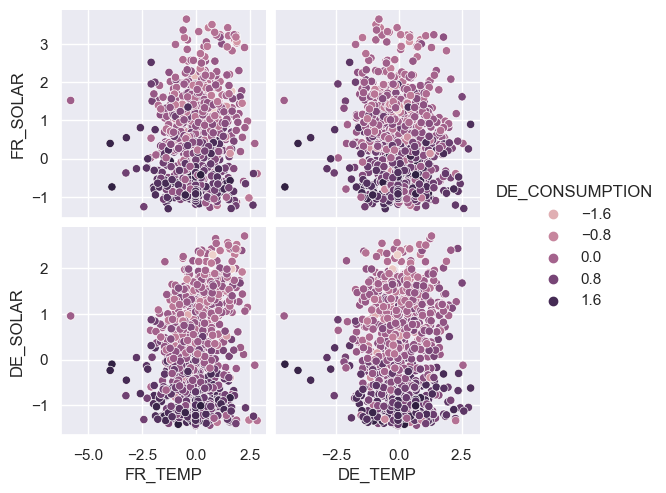

In [78]:
plt.clf()
sns.pairplot(data=df_numeric, x_vars=['FR_TEMP', 'DE_TEMP'], y_vars=['FR_SOLAR', 'DE_SOLAR'], hue='DE_CONSUMPTION')
plt.show()

Temperature should affect photovoltaic energy generation as there is a correlation between sunlight and temperature (cloud cover would reduce both temperature and sunlight, for example), and since high temperatures would cause solar panels to decline in performance (increasing resistance, damaging parts), potentially to the point of not being operable. This is perhaps made up for by other means of solar energy production, notably the use of solar energy to evaporate water into steam for turbine based generators. Overall though, this empirically seems to be less important in comparison to other factors though not negligible (Germany uses solar for roughly 10%, France 20%).

May be something to revisit, though at the moment it seems like temperature is most useful for calculating energy consumption, as the most energy intensive (residential) use is in heating and cooling, hence we may expect some kind of relationship between the mean squared distance temperature is from the ideal indoor temperature and energy consumption.

<Figure size 1200x1000 with 0 Axes>

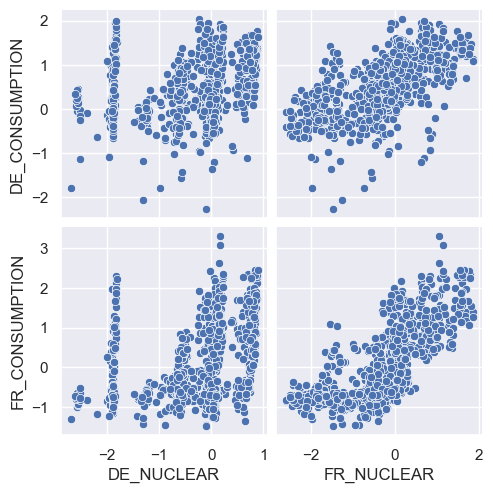

In [79]:
plt.clf()
sns.pairplot(data=df_numeric, x_vars=['DE_NUCLEAR', 'FR_NUCLEAR'], y_vars=['DE_CONSUMPTION', 'FR_CONSUMPTION'])
plt.show()

Germany has 3 nuclear reactors (which will be shutting down soon), hence the vertical bands produced in the graphs related to DE_NUCLEAR: the eight combinations of reactors (which may individually have different output levels) account relatively well for the structure of the plots. Additionally, the number of active reactors may be indicative of other conditions, as reactors may be used to make up for insufficient production elsewhere (i.e. during periods of low wind or sunlight).

On the other hand, France has 56, so the bands aren't present, though we do see a clear trend in nuclear energy production when consumption and thus demand is higher—this is easily explained by the vast majority of energy in France being from nuclear energy (in the 70 something percent range). Something of note in French energy production, however, is the use of coal: similar to German nuclear energy, it seems to be put into use only when needed, as there are a large amount of points at the minimum value of FR_COAL, implying certain conditions where coal energy is not being produced at all.

These observations are notable, as they present a clear difference in the analysis of energy production between countries, as well as that of renewable and non-renewable means: energy production based on natural factors (wind, hydroelectric, photovoltaic) are for the most part in reaction to conditions outside of human control, with the exception of thresholds such as cut-in and cut-out times of wind turbines that simply halt or begin production in reaction to external factors, which otherwise control the rate. On the other hand, energy produced by consumption of non-renewable resources such as gas or coal is entirely in the control of the country, which must decide whether to activate certain plants or not. Since electricity prices are heavily influenced by excess energy (see "Nonlinear Excess Demand Model for Electricity Price Prediction", Soytas et. al.), it seems reasonable to predict price fluctuations in energy by the excess or insufficient energy produced by renewable means, as these factors are the most unpredictable and therefore most likely to cause an over- or underproduction of electricity.

<Figure size 1200x1000 with 0 Axes>

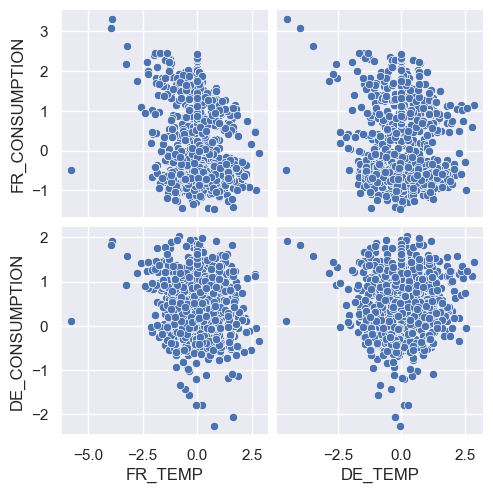

In [80]:
plt.clf()
sns.pairplot(data=df_numeric, x_vars=['FR_TEMP', 'DE_TEMP'], y_vars=['FR_CONSUMPTION', 'DE_CONSUMPTION'])
plt.show()

In [86]:
mir(df_numeric, y['TARGET'])

array([0.01731758, 0.02952705, 0.        , 0.03438251, 0.04808459,
       0.03413793, 0.00448216, 0.01096475, 0.01703927, 0.00397924,
       0.00512543, 0.01832092, 0.01566193, 0.00286092, 0.01936712,
       0.05721436, 0.02047226, 0.04297923, 0.06168685, 0.        ,
       0.03798544, 0.00516434, 0.04666882, 0.02606409, 0.02741674,
       0.        , 0.01891899, 0.        , 0.01318696, 0.04632199,
       0.04731202, 0.04950368])

In [88]:
df_numeric.columns

Index(['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'DE_WIND_OTHER_POW', 'DE_WIND_SQCB', 'DE_WIND_SQRT'],
      dtype='object')

In [89]:
df_numeric.describe()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,DE_WIND_OTHER_POW,DE_WIND_SQCB,DE_WIND_SQRT
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000
mean,0.427442,-0.020032,-0.145822,0.260529,0.064580,0.780699,0.395019,-0.134330,-0.434518,0.537398,0.105639,-0.468190,-0.446805,0.246707,0.608185,0.146337,0.398426,-0.298856,0.071633,-0.153688,-0.052747,0.003785,0.086134,0.100944,0.007201,0.006561,0.058126,0.061724,0.080510,1.624268,1.529028,1.361620
std,0.673412,0.918995,0.962071,0.916927,1.050937,0.850190,0.906500,0.847285,0.506141,1.086330,1.057867,0.902468,0.964543,1.069899,1.079398,1.064187,1.189404,0.851339,0.851499,0.896325,0.954484,1.019906,1.026417,1.024526,0.941325,0.971283,1.097768,1.033853,1.098624,0.615753,0.510377,0.335588
min,-2.265563,-1.462350,-2.856874,-2.279619,-1.951516,-1.117260,-1.317350,-1.491593,-0.794950,-1.373985,-1.758523,-2.689387,-2.595326,-1.442296,-1.312588,-1.235802,-1.143277,-2.879041,-2.613569,-1.678936,-2.128531,-1.726420,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790,0.000000,0.000000,0.000000
25%,-0.037421,-0.716771,-0.869990,-0.395910,-0.774676,0.134947,-0.205078,-0.833046,-0.779098,-0.314520,-0.693892,-0.954908,-1.228912,-0.731345,-0.311343,-0.688284,-0.527749,-0.787239,-0.422896,-0.802333,-0.618791,-0.488625,-0.633867,-0.645796,-0.577139,-0.597690,-0.624238,-0.458038,-0.522968,1.179730,1.158262,1.116491
50%,0.357061,-0.394166,-0.164287,0.306899,-0.099455,0.740006,0.256780,-0.246732,-0.766389,0.330832,-0.138049,-0.097032,-0.327874,0.211219,0.566797,-0.091336,0.007051,-0.188300,0.151799,-0.460160,-0.274901,-0.228147,-0.261571,-0.229031,-0.026306,-0.020889,0.008493,0.063312,0.054056,1.435174,1.378703,1.272340
75%,0.922057,0.650533,0.631683,0.921263,0.820640,1.399461,1.090646,0.485761,-0.262886,1.282374,0.776483,0.100720,0.143426,1.158397,1.368670,0.644247,1.010071,0.273510,0.621209,0.382191,0.274779,0.125947,0.587377,0.677040,0.569285,0.650856,0.676415,0.641446,0.599094,1.968936,1.826161,1.570921
max,2.033851,3.300640,2.634831,2.464849,2.825331,3.118082,2.372570,2.324889,1.905512,4.181936,3.730478,0.893087,1.854408,2.696571,3.648905,3.509017,4.965793,1.586885,2.539576,2.918326,7.756118,9.473201,5.085624,4.965028,2.858758,2.817239,5.674778,3.746576,5.471818,4.287850,3.647462,2.639326


In [17]:
km = KMeans(n_clusters=2)
km.fit(df_numeric)
km.labels_
df_clustered = df_numeric.copy()
df_clustered['CLUSTER'] = km.labels_
# sns.pairplot(data=df_clustered, vars=['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
#       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
#       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
#       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
#       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
#       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET'], hue='CLUSTER')

In [18]:
df_clustered.columns

Index(['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE', 'DE_NET_IMPORT',
       'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL', 'FR_COAL', 'DE_HYDRO',
       'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR', 'DE_SOLAR', 'FR_SOLAR',
       'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE', 'DE_RESIDUAL_LOAD',
       'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND', 'FR_WIND',
       'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'DE_WIND_OTHER_POW', 'DE_WIND_SQCB', 'DE_WIND_SQRT', 'CLUSTER'],
      dtype='object')

### Further Data Cleaning / Feature Engineering

Removing duplicate data (columns that are just the negative of each other), other data cleaning, and looking for good transformers.

In [19]:
x_train_clean = bx_train.drop(['ID', 'DAY_ID', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1).fillna(bx_train.mean(numeric_only=True))
x_test_clean = bx_test.drop(['ID', 'DAY_ID', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1).fillna(bx_train.mean(numeric_only=True))
x_train_clean['COUNTRY'] = x_train_clean['COUNTRY'].factorize()[0]
x_test_clean['COUNTRY'] = x_test_clean['COUNTRY'].factorize()[0]

#### Polynomial basis

In [116]:
poly = PolynomialFeatures(3)
poly_x_train_clean = poly.fit_transform(x_train_clean)
poly_x_test_clean = poly.fit_transform(x_test_clean)

In [117]:
km = KMeans(n_clusters=5)
km.fit(x_train_clean)
x_train_clustered = x_train_clean.copy()
x_train_clustered['CLUSTER'] = km.labels_
x_test_clustered = x_test_clean.copy()
x_test_clustered['CLUSTER'] = km.predict(x_test_clean)

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [98]:
new_features = df.copy().drop(['ID', 'DAY_ID', 'FR_DE_EXCHANGE', 'FR_NET_EXPORT', 'DE_NET_EXPORT'], axis=1).fillna(df.mean(numeric_only=True))
new_features['COUNTRY'] = new_features['COUNTRY'].factorize()[0]
new_features['DE_NON_RENEWABLE'] = new_features['DE_GAS'] + new_features['DE_COAL'] + new_features['DE_LIGNITE'] + new_features['DE_NUCLEAR']
new_features['DE_RENEWABLE'] = new_features['DE_HYDRO'] + new_features['DE_SOLAR'] + new_features['DE_WINDPOW']
new_features['DE_EXCESS_ENERGY'] = new_features['DE_NON_RENEWABLE'] + new_features['DE_RENEWABLE'] - new_features['DE_CONSUMPTION']
new_features['TARGET'] = y['TARGET']

In [132]:
new_features['DE_WIND_SQCB'] = (new_features['DE_WIND'] - new_features['DE_WIND'].min()).pow(2.0/3.0)
new_features['FR_WIND_SQCB'] = (new_features['FR_WIND'] - new_features['FR_WIND'].min()).pow(2.0/3.0)

### Models

Trying various models.

TODO read through and implement stuff from here, paper notes that drivers of electricity prices are nonlinear: https://www.sciencedirect.com/science/article/pii/S0301421518307432

#### Hyperparameters

In [90]:
# threshold values for cut-in speeds of German and French wind turbines, respectively.
de_wind_switch = 0
fr_wind_switch = 0

In [261]:
# for fitting two part linear regression to WIND_SQCB / WINDPOW to determine excess production
# in general, given two series and a threshold (boolean) function, the fn will split the the x and y values
# based on the function and then do ols on each side, returning a new series with the residual
# of each y-value from the fitted line

def lr_sd(lr, x, y):
    return (y - lr.predict(x)).pow(2).sum() / y.size

def double_lr(d, x, y, f):
    data = d[[x, y]].copy()
    d1, d2 = data[f(data[x], data[y])], data[~ f(data[x], data[y])]
    lr1, lr2 = LinearRegression(), LinearRegression()
    lr1.fit(d1[x].values.reshape(-1, 1), d1[y])
    lr2.fit(d2[x].values.reshape(-1, 1), d2[y])
    sd1, sd2 = lr_sd(lr1, d1[[x]], d1[y]), lr_sd(lr2, d2[[x]], d2[y])
    p = lambda r : ((r[2] - lr1.predict([[r[1]]])) / sd1) if f(r[1], r[2]) else ((r[2] - lr2.predict([[r[1]]])) / sd2)
    return pd.Series([float(p(row)) for row in data.itertuples()])

In [302]:
new_features['DE_WIND_EXCESS'] = double_lr(new_features, 'DE_WIND_SQCB', 'DE_WINDPOW', lambda x, y : x > 1.5)
new_features['FR_WIND_EXCESS'] = double_lr(new_features, 'FR_WIND_SQCB', 'FR_WINDPOW', lambda x, y : x > 1.5)

/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(
/Users/apple/anaconda3/lib/python3.10/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but LinearRegression was fitted without feature names
  warnings.warn(


<Axes: xlabel='FR_WIND_EXCESS', ylabel='Count'>

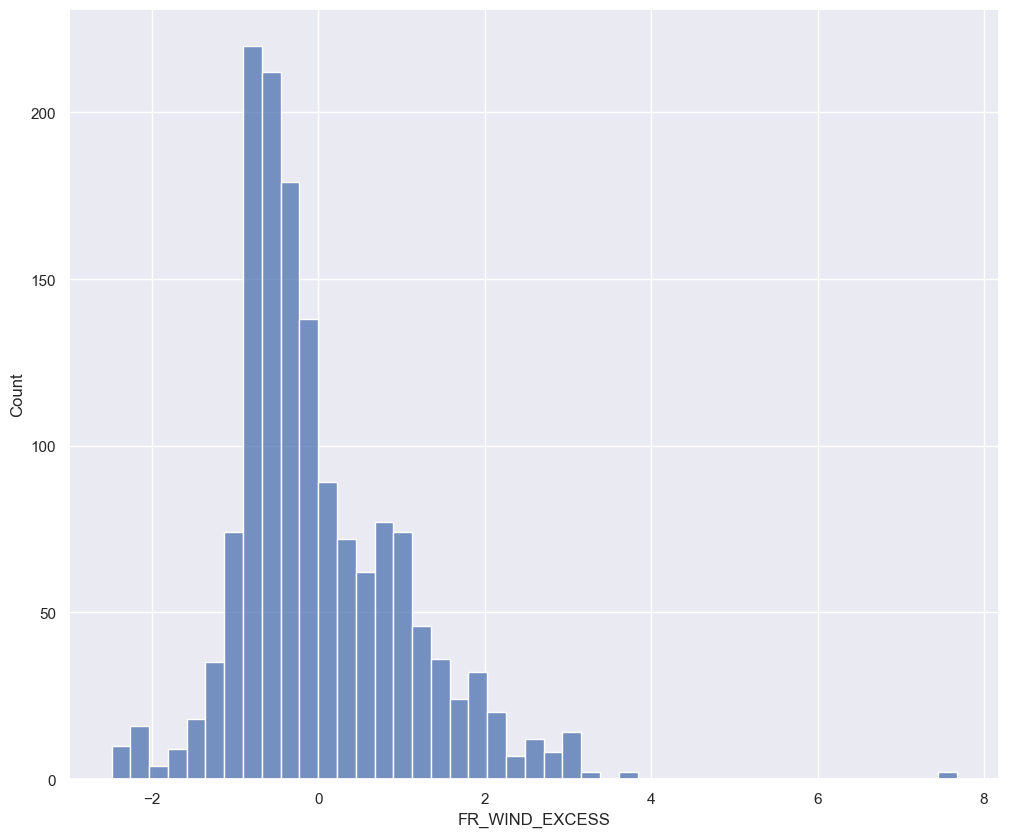

In [303]:
sns.histplot(data=new_features, x='FR_WIND_EXCESS')

In [304]:
new_features.describe()

,COUNTRY,DE_CONSUMPTION,FR_CONSUMPTION,DE_FR_EXCHANGE,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND,FR_WIND,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,DE_NON_RENEWABLE,DE_RENEWABLE,DE_EXCESS_ENERGY,TARGET,DE_WIND_SQCB,FR_WIND_SQCB,DE_WIND_EXCESS,FR_WIND_EXCESS
count,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1494.000000,1.494000e+03,1.494000e+03
mean,0.430388,0.427442,-0.020032,-0.145508,0.256332,0.072643,0.780699,0.395019,-0.134330,-0.434518,0.537398,0.105639,-0.468190,-0.446805,0.246707,0.608185,0.146337,0.398426,-0.298856,0.071633,-0.153688,-0.037831,0.019357,0.109480,0.123099,0.009451,0.008404,0.058126,0.061724,0.080510,-0.120676,0.930442,0.382324,0.089934,1.541823,1.555031,-2.443382e-16,-2.699016e-16
std,0.495296,0.673412,0.918995,0.962068,0.916821,1.050307,0.850190,0.906500,0.847285,0.506141,1.086330,1.057867,0.902468,0.964543,1.069899,1.079398,1.064187,1.189404,0.851339,0.851499,0.896325,0.952745,1.018132,1.022452,1.020950,0.941285,0.971257,1.097768,1.033853,1.098624,2.411726,1.541162,1.831392,1.034582,0.508995,0.518827,1.174283e+00,1.040453e+00
min,0.000000,-2.265563,-1.462350,-2.856874,-2.279619,-1.951516,-1.117260,-1.317350,-1.491593,-0.794950,-1.373985,-1.758523,-2.689387,-2.595326,-1.442296,-1.312588,-1.235802,-1.143277,-2.879041,-2.613569,-1.678936,-2.128531,-1.726420,-1.880419,-1.895319,-4.549638,-5.787097,-5.349463,-5.706442,-4.281790,-6.268161,-3.003775,-4.654684,-6.519268,0.000000,0.000000,-2.977833e+00,-2.487401e+00
25%,0.000000,-0.037421,-0.716771,-0.869990,-0.395910,-0.774676,0.134947,-0.205078,-0.833046,-0.779098,-0.314520,-0.693892,-0.954908,-1.228912,-0.731345,-0.311343,-0.688284,-0.527749,-0.787239,-0.422896,-0.802333,-0.618791,-0.488625,-0.633867,-0.645796,-0.577139,-0.597690,-0.624238,-0.458038,-0.522968,-1.763976,-0.244564,-0.927469,-0.219861,1.158262,1.160102,-8.089578e-01,-6.902502e-01
50%,0.000000,0.357061,-0.394166,-0.145508,0.256332,-0.041508,0.740006,0.256780,-0.246732,-0.766389,0.330832,-0.138049,-0.097032,-0.327874,0.211219,0.566797,-0.091336,0.007051,-0.188300,0.151799,-0.460160,-0.211042,-0.193154,-0.193572,-0.146217,0.009451,0.008404,0.008493,0.063312,0.054056,-0.290190,0.904099,0.440866,0.000000,1.417046,1.451699,-2.231198e-01,-2.830854e-01
75%,1.000000,0.922057,0.650533,0.631683,0.921263,0.820640,1.399461,1.090646,0.485761,-0.262886,1.282374,0.776483,0.100720,0.143426,1.158397,1.368670,0.644247,1.010071,0.273510,0.621209,0.382191,0.274779,0.125947,0.587377,0.677040,0.569285,0.650856,0.676415,0.641446,0.599094,1.494287,2.003165,1.760873,0.269719,1.826161,1.877389,5.644838e-01,6.067060e-01
max,1.000000,2.033851,3.300640,2.634831,2.464849,2.825331,3.118082,2.372570,2.324889,1.905512,4.181936,3.730478,0.893087,1.854408,2.696571,3.648905,3.509017,4.965793,1.586885,2.539576,2.918326,7.756118,9.473201,5.085624,4.965028,2.858758,2.817239,5.674778,3.746576,5.471818,7.116833,5.675232,5.473160,7.786578,3.647462,3.610473,4.829084e+00,7.674791e+00


In [313]:
new_features.columns

Index(['COUNTRY', 'DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_FR_EXCHANGE',
       'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND',
       'FR_WIND', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET',
       'DE_NON_RENEWABLE', 'DE_RENEWABLE', 'DE_EXCESS_ENERGY', 'TARGET',
       'DE_WIND_SQCB', 'FR_WIND_SQCB', 'DE_WIND_EXCESS', 'FR_WIND_EXCESS'],
      dtype='object')

In [329]:
# take desired features from list of all in new_features
x = new_features[['DE_CONSUMPTION', 'FR_CONSUMPTION', 'DE_NET_IMPORT', 'FR_NET_IMPORT', 'DE_GAS', 'FR_GAS', 'DE_COAL',
       'FR_COAL', 'DE_HYDRO', 'FR_HYDRO', 'DE_NUCLEAR', 'FR_NUCLEAR',
       'DE_SOLAR', 'FR_SOLAR', 'DE_WINDPOW', 'FR_WINDPOW', 'DE_LIGNITE',
       'DE_RESIDUAL_LOAD', 'FR_RESIDUAL_LOAD', 'DE_RAIN', 'FR_RAIN', 'DE_WIND_SQCB',
       'FR_WIND_SQCB', 'DE_TEMP', 'FR_TEMP', 'GAS_RET', 'COAL_RET', 'CARBON_RET', 'DE_WIND_EXCESS', 'FR_WIND_EXCESS']]

In [330]:
# perform train test split after features have been calculated
x_train, x_test, y_train, y_test = train_test_split(x, y['TARGET'], test_size=0.33, random_state=88)

In [331]:
x_train.head()

,DE_CONSUMPTION,FR_CONSUMPTION,DE_NET_IMPORT,FR_NET_IMPORT,DE_GAS,FR_GAS,DE_COAL,FR_COAL,DE_HYDRO,FR_HYDRO,DE_NUCLEAR,FR_NUCLEAR,DE_SOLAR,FR_SOLAR,DE_WINDPOW,FR_WINDPOW,DE_LIGNITE,DE_RESIDUAL_LOAD,FR_RESIDUAL_LOAD,DE_RAIN,FR_RAIN,DE_WIND_SQCB,FR_WIND_SQCB,DE_TEMP,FR_TEMP,GAS_RET,COAL_RET,CARBON_RET,DE_WIND_EXCESS,FR_WIND_EXCESS
429,-0.342342,-0.900615,1.302685,-0.867090,1.331706,0.203858,-1.329571,-0.782493,1.665186,1.229521,0.040479,-1.034820,1.538853,0.976819,-0.544290,-0.593432,-1.654547,-0.217661,-0.827094,0.294262,-0.509231,1.043373,1.127288,0.328277,0.532017,0.000000,0.011165,1.934400,-0.308905,-0.885287
390,1.819470,1.055997,-1.425359,-0.716766,-0.285441,0.046890,-0.937467,-0.438559,-0.199822,0.583891,-0.251106,0.729625,-0.835072,-0.575911,3.509017,3.445793,-2.445831,-1.596095,0.315319,1.294341,0.671642,1.855772,1.688704,0.870069,1.569758,1.621041,0.292173,-0.366159,2.852970,1.954111
927,-0.101861,-0.990559,-1.340673,-0.103656,-0.921158,-1.279963,-1.335088,-0.777164,-0.288322,-0.815095,-0.802385,-1.102109,1.808312,-0.502585,2.042065,0.619386,-2.879041,-2.409883,-1.070319,-0.100753,0.626825,1.690016,1.360430,-0.042395,0.316972,-2.745587,-1.795210,-1.593536,1.759191,0.154055
1162,0.367791,-0.387516,0.925296,-0.794419,0.561807,-0.278742,-0.890191,-0.766000,3.245487,-0.403496,-0.076801,-0.189876,1.733999,1.623467,0.056738,-0.285646,-1.143696,-0.337547,-0.429607,-0.175144,-0.098820,1.337204,1.387399,-1.118827,0.250535,2.563272,-0.788171,0.807729,-0.380046,-1.271903
1195,1.529624,1.225922,-1.122356,0.312239,0.540736,0.967786,0.720429,0.620217,0.266687,-0.373837,-1.828979,0.180241,-0.752510,0.045159,1.800818,2.739241,-0.637638,-0.575167,0.607091,0.467226,-0.303052,2.806588,2.563893,1.336073,-0.004579,-0.760330,-0.200230,-1.523625,0.184866,0.853509


#### Baseline Linear Regression

In [332]:
lr_bench = LinearRegression()
lr_bench.fit(x_train, y_train)
test_output = lr_bench.predict(x_test)
print('Spearman correlation for ridge regression: {:.1f}%'.format(100 * metric_train(test_output, y_test)))
test_output = lr_bench.predict(x_train)
print(spearmanr(test_output, y_train).correlation)

Spearman correlation for ridge regression: 20.5%
0.24505290573285257


#### Linear Regression on Polynomial Basis

In [333]:
br_lr.fit(poly_x_train_clean, y_train_clean)
poly_lr_test_output = br_lr.predict(poly_x_test_clean)
print('Spearman correlation for linear regression on polynomial basis: {:.1f}%'.format(100 * metric_train(poly_lr_test_output, y_test_clean)))
poly_lr_test_output = br_lr.predict(poly_x_train_clean)
print(spearmanr(poly_lr_test_output, y_train_clean).correlation)

Spearman correlation for linear regression on polynomial basis: 6.5%
0.9999996399995753


#### Ridge Regression

In [334]:
reg = linear_model.Ridge(alpha=0.6)
reg.fit(x_train, y_train)
ridge_test_output = reg.predict(x_test)
print('Spearman correlation for ridge regression: {:.1f}%'.format(100 * metric_train(ridge_test_output, y_test)))
ridge_test_output = reg.predict(x_train)
print(spearmanr(ridge_test_output, y_train).correlation)

Spearman correlation for ridge regression: 20.8%
0.24658496114474013


#### Decision Tree Regression

Noted two separate linear trends in the DE_WIND - DE_WINDPOW data, testing if DRT works.

In [335]:
drt = DecisionTreeRegressor(random_state=88, max_features='sqrt')

drt.fit(x_train, y_train)

drt_test_output = drt.predict(x_test)

print('Spearman correlation for decision tree regression: {:.1f}%'.format(100 * metric_train(drt_test_output, y_test) ))

drt_test_output = drt.predict(x_train)
print(spearmanr(drt_test_output, y_train).correlation)

Spearman correlation for decision tree regression: 11.6%
0.798893835103501


#### XGB Linear Regression

In [336]:
xgb_model = xgb.XGBRegressor(objective="reg:squarederror", random_state=88, eta=0.3, gamma=15, max_depth=5)

xgb_model.fit(x_train, y_train)

xgb_test_output = xgb_model.predict(x_test)

print('Spearman correlation for XGB: {:.1f}%'.format(100 * metric_train(xgb_test_output, y_test)))
xgb_test_output = xgb_model.predict(x_train)
print(spearmanr(xgb_test_output, y_train).correlation)

Spearman correlation for XGB: 26.4%
0.31756019449134915
